### SPATIAL FEATURES AND SEPARATE REGRESSIONS

In [1]:
# Modules.
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
import osmnx as ox
from shapely.geometry import box, Point

In [2]:
# Paths.
final_path = Path("data/model/nyc_tract_summer_2025_final.csv")
tract_shp_path = Path("data/nyc_tracts_2020/nyc_tracts_2020.shp")

model_dir = Path("data/model")
model_dir.mkdir(exist_ok = True, parents = True)

# Data load.
model_data = pd.read_csv(final_path)

# Initial filter for 0 population.
model_data = model_data[model_data["TOTAL_POP"] > 0].copy()

In [3]:
# Merge with shapefile.
gdf_main = gpd.read_file(tract_shp_path)

# Align GEOID.
model_data["GEOID"] = model_data["GEOID"].astype(str)
gdf_main["GEOID"] = gdf_main["geoid"].astype(str)

# Merge geometry.
model_data = pd.merge(
    model_data.drop(columns = ["LATITUDE", "LONGITUDE"]),
    gdf_main[["GEOID", "geometry"]],
    on = "GEOID",
    how = "left"
)

# Create GeoDataFrame.
target_crs = "EPSG:2263"
gdf_tracts = gpd.GeoDataFrame(model_data, geometry = "geometry", crs = gdf_main.crs).to_crs(target_crs)

In [4]:
# Spatial feature helper functions.
def get_knn_distance(source_gdf, target_gdf, k = 1):
    source_coords = np.column_stack((source_gdf.geometry.x, source_gdf.geometry.y))
    target_coords = np.column_stack((target_gdf.geometry.x, target_gdf.geometry.y))

    neighbors = NearestNeighbors(n_neighbors = k, algorithm = "ball_tree").fit(target_coords)
    distances, _ = neighbors.kneighbors(source_coords)

    return distances[:, k-1]

def get_density_count(source_gdf, target_gdf, radius_feet = 1000):
    source_coords = np.column_stack((source_gdf.geometry.x, source_gdf.geometry.y))
    target_coords = np.column_stack((target_gdf.geometry.x, target_gdf.geometry.y))

    neighbors = NearestNeighbors(radius = radius_feet, algorithm = "ball_tree").fit(target_coords)
    distances, indices = neighbors.radius_neighbors(source_coords)

    return [len(x) for x in indices]

In [5]:
# Spatial features using osmnx.

ox.settings.use_cache = True
ox.settings.log_console = True

place = "New York City, New York, USA"

subways = ox.features_from_place(place, tags = {"railway": "subway_entrance"}).to_crs(target_crs)

parks = ox.features_from_place(place, tags = {"leisure": "park"}).to_crs(target_crs)
parks = parks[parks.geometry.area > 2000].copy() # Filter small parks.
parks["geometry"] = parks.geometry.centroid

# POIs.
poi_tags = {"amenity": ["bar", "pub", "nightclub", "restaurant"], "shop": ["convenience", "supermarket"]}
pois = ox.features_from_place(place, tags = poi_tags).to_crs(target_crs)
pois["geometry"] = pois.geometry.centroid

# Convert tracts to centroids.
gdf_tracts_centroids = gdf_tracts.copy()
gdf_tracts_centroids["geometry"] = gdf_tracts_centroids.geometry.centroid

print("k-Nearest Neighbors: Subway")
model_data["KNN_SUBWAY"] = get_knn_distance(gdf_tracts_centroids, subways)
print("k-Nearest Neighbors: Parks")
model_data["KNN_PARKS"] = get_knn_distance(gdf_tracts_centroids, parks)
print("POI Density")
model_data["POI_DENSITY"] = get_density_count(gdf_tracts_centroids, pois, radius_feet = 1000)

# Print check.
print("Spatial features done.")

k-Nearest Neighbors: Subway
k-Nearest Neighbors: Parks
POI Density
Spatial features done.


In [6]:
# Predictor lists.
heat_variables = ["TEMP_MAX_F"]
env_variables = ["TREE_CANOPY_PCT"]
acs_variables = ["PCT_BACHELORS_PLUS", "PCT_RENTERS", "PCT_LIMITED_ENGLISH", "MEDIAN_INCOME"]
urban_variables = ["KNN_SUBWAY", "POI_DENSITY", "KNN_PARKS"]
interaction_terms = ["TEMP_MAX_F * TREE_CANOPY_PCT", "TEMP_MAX_F * POI_DENSITY"]

In [7]:
# Note: Basic model without scaling generally used to communicate findings.
# Scaled model used to prove relationships are robust and compare their strengths.
# Will need to use scaled for this case due to SHAP implementation.

# Helper function for fit model with scaling.
def fit_model_scaled(data_frame, formula):
    # Renamed to fit_model_scaled for clarity when running suite.
    df_scaled = data_frame.copy()
    
    # Parse formula for numeric predictors.
    formula_parts = formula.split("~")
    rhs = formula_parts[1].strip()
    main_predictors = [p.strip() for p in rhs.split("+") if "*" not in p]
    numeric_cols = [c for c in main_predictors if df_scaled[c].dtype in [np.float64, np.int64] and c != "EXTREME_HEAT"]

    # Scale.
    scaler = StandardScaler()
    df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
    
    # Fit.
    model = smf.ols(formula, data = df_scaled).fit(cov_type = "HC3")
    
    print(f"R-Squared: {model.rsquared:.3f} | AIC: {model.aic:.1f}")

    return model

# Helper function for fit model without scaling.
def fit_model_basic(data_frame, formula):
    # Uses raw data (no scaling) for coefficients with natural units.
    # Note: The condition numbers were HIGH for the basic model. Apparently it's because the predictors used here are not very numerically stable.
    # Predictor numbers for income are 80,000 vs. really small percentages or proportions that can be 0.0385 for example,
    # the regression model struggles doing the math behind the scenes due to the magnitude of difference.
    model = smf.ols(formula, data = data_frame).fit(cov_type = "HC3")
    
    print(f"R-Squared: {model.rsquared:.3f} | AIC: {model.aic:.1f}")

    return model

# Helper function to actually run the models.
# Makes it a LOT easier to adjust the predictors rather than constantly copying and pasting because I got annoyed with that.
def run_model_suite(df, label, scaled = True):
    """
    Runs the model suite using either scaled or basic OLS fitting.
    :param df: The DataFrame (e.g. df_high_daily).
    :param label: Label for printing (e.g. "Daily: Extreme Heat").
    :param scaled: If True, uses fit_model_scaled (for stability/comparison); 
                   If False, uses fit_model_basic (for raw coefficient magnitude).
    """
    
    # Select the fitting function based on the scaled parameter.
    fit_function = fit_model_scaled if scaled else fit_model_basic
    
    print(f"\nRunning Models for: {label} (Scaled: {scaled})")
    
    # Formulas.
    # f1, f2, f3, f4, etc. must use variables defined globally
    f1 = f"QOL_RATE_1K ~ {' + '.join(heat_variables)}"
    f2 = f1 + " + " + " + ".join(env_variables)
    f3 = f2 + " + " + " + ".join(acs_variables)
    f4 = f3 + " + " + " + ".join(urban_variables)
    
    # Run models.
    print("1. Base Heat"); m1 = fit_function(df, f1)
    print("2. + Env"); m2 = fit_function(df, f2)
    print("3. + ACS"); m3 = fit_function(df, f3)
    print("4. + Urban (Full)"); m4 = fit_function(df, f4)
    
    return {"heat_first": m1, "environment_second": m2, "acs_third": m3, "urban_fourth": m4}

In [8]:
# Calculate daily rates.
model_data["QOL_RATE_1K"] = (model_data["QOL_CALLS"] / model_data["TOTAL_POP"]) * 1000

# Split into heat categories.
df_high_daily = model_data[model_data["EXTREME_HEAT"] == 1].copy()
df_norm_daily = model_data[model_data["EXTREME_HEAT"] == 0].copy()

print(f"Daily Observations for High Heat: {df_high_daily.shape[0]}")
print(f"Daily Observations for Normal Heat: {df_norm_daily.shape[0]}")

Daily Observations for High Heat: 11145
Daily Observations for Normal Heat: 185007


In [11]:
# Run daily models.
print("\nDaily Models")
scaled_model_high_daily = run_model_suite(df_high_daily, "Daily: Extreme Heat", scaled = True)
scaled_model_norm_daily = run_model_suite(df_norm_daily, "Daily: Normal Heat", scaled = True)


Daily Models

Running Models for: Daily: Extreme Heat (Scaled: True)
1. Base Heat
R-Squared: 0.000 | AIC: 34175.9
2. + Env
R-Squared: 0.002 | AIC: 34158.0
3. + ACS
R-Squared: 0.022 | AIC: 33936.1
4. + Urban (Full)
R-Squared: 0.023 | AIC: 33935.7

Running Models for: Daily: Normal Heat (Scaled: True)
1. Base Heat
R-Squared: 0.000 | AIC: 623798.7
2. + Env
R-Squared: 0.002 | AIC: 623577.2
3. + ACS
R-Squared: 0.017 | AIC: 620764.1
4. + Urban (Full)
R-Squared: 0.017 | AIC: 620657.6


In [74]:
# Basic model that is NOT scaled below.
basic_model_high_daily = run_model_suite(df_high_daily, "Daily: Extreme Heat", scaled = False)
basic_model_norm_daily = run_model_suite(df_norm_daily, "Daily: Normal Heat", scaled = False)


Running Models for: Daily: Extreme Heat (Scaled: False)
1. Base Heat
R-Squared: 0.000 | AIC: 34175.9
2. + Env
R-Squared: 0.002 | AIC: 34158.0
3. + ACS
R-Squared: 0.022 | AIC: 33936.1
4. + Urban (Full)
R-Squared: 0.023 | AIC: 33935.7

Running Models for: Daily: Normal Heat (Scaled: False)
1. Base Heat
R-Squared: 0.000 | AIC: 623798.7
2. + Env
R-Squared: 0.002 | AIC: 623577.2
3. + ACS
R-Squared: 0.017 | AIC: 620764.1
4. + Urban (Full)
R-Squared: 0.017 | AIC: 620657.6


In [75]:
# Weekly aggregation.
# Create week column for aggregation.
df_high_daily["DATE"] = pd.to_datetime(df_high_daily["DATE"])
df_high_daily["WEEK"] = df_high_daily["DATE"].dt.isocalendar().week

df_norm_daily["DATE"] = pd.to_datetime(df_norm_daily["DATE"])
df_norm_daily["WEEK"] = df_norm_daily["DATE"].dt.isocalendar().week

In [62]:
# Sum dynamic variable calls, mean weather variables, and keep static variables.
aggregation = {
    "QOL_CALLS": "sum",
    "TOTAL_POP": "first",
    "TEMP_MAX_F": "mean",
    "PRCP_IN": "mean"
}

# Add all static predictors to aggregation list.
static_variables = env_variables + acs_variables + urban_variables
for v in static_variables:
    aggregation[v] = "first"

In [63]:
# High Heat Weeks.
df_high_weekly = df_high_daily.groupby(["GEOID", "WEEK"]).agg(aggregation).reset_index()
df_high_weekly["QOL_RATE_1K"] = (df_high_weekly["QOL_CALLS"] / df_high_weekly["TOTAL_POP"]) * 1000

# Normal Heat Weeks.
df_norm_weekly = df_norm_daily.groupby(["GEOID", "WEEK"]).agg(aggregation).reset_index()
df_norm_weekly["QOL_RATE_1K"] = (df_norm_weekly["QOL_CALLS"] / df_norm_weekly["TOTAL_POP"]) * 1000

print(f"Weekly Observations for High Heat: {df_high_weekly.shape[0]}")
print(f"Weekly Observations for Normal Heat: {df_norm_weekly.shape[0]}")

Weekly Observations for High Heat: 4458
Weekly Observations for Normal Heat: 31206


In [76]:
print("\nWeekly Models")
# Note: R-squared should be significantly higher for weekly data due to noise reduction, daily just has a lot going on.
scaled_model_high_weekly = run_model_suite(df_high_weekly, "Weekly: Extreme Heat", scaled = True)
scaled_model_norm_weekly = run_model_suite(df_norm_weekly, "Weekly: Normal Heat", scaled = True)


Weekly Models

Running Models for: Weekly: Extreme Heat (Scaled: True)
1. Base Heat
R-Squared: 0.012 | AIC: 20002.8
2. + Env
R-Squared: 0.014 | AIC: 19992.9
3. + ACS
R-Squared: 0.045 | AIC: 19861.0
4. + Urban (Full)
R-Squared: 0.045 | AIC: 19863.1

Running Models for: Weekly: Normal Heat (Scaled: True)
1. Base Heat
R-Squared: 0.004 | AIC: 195504.1
2. + Env
R-Squared: 0.006 | AIC: 195432.7
3. + ACS
R-Squared: 0.036 | AIC: 194506.1
4. + Urban (Full)
R-Squared: 0.037 | AIC: 194474.6


In [77]:
# Basic model that is NOT scaled below.
basic_model_high_weekly = run_model_suite(df_high_weekly, "Weekly: Extreme Heat", scaled = False)
basic_model_norm_weekly = run_model_suite(df_norm_weekly, "Weekly: Normal Heat", scaled = False)


Running Models for: Weekly: Extreme Heat (Scaled: False)
1. Base Heat
R-Squared: 0.012 | AIC: 20002.8
2. + Env
R-Squared: 0.014 | AIC: 19992.9
3. + ACS
R-Squared: 0.045 | AIC: 19861.0
4. + Urban (Full)
R-Squared: 0.045 | AIC: 19863.1

Running Models for: Weekly: Normal Heat (Scaled: False)
1. Base Heat
R-Squared: 0.004 | AIC: 195504.1
2. + Env
R-Squared: 0.006 | AIC: 195432.7
3. + ACS
R-Squared: 0.036 | AIC: 194506.1
4. + Urban (Full)
R-Squared: 0.037 | AIC: 194474.6


XGBoost R2 (Weekly SHAP: Extreme Heat): 0.794


 98%|===================| 4360/4458 [00:23<00:00]        

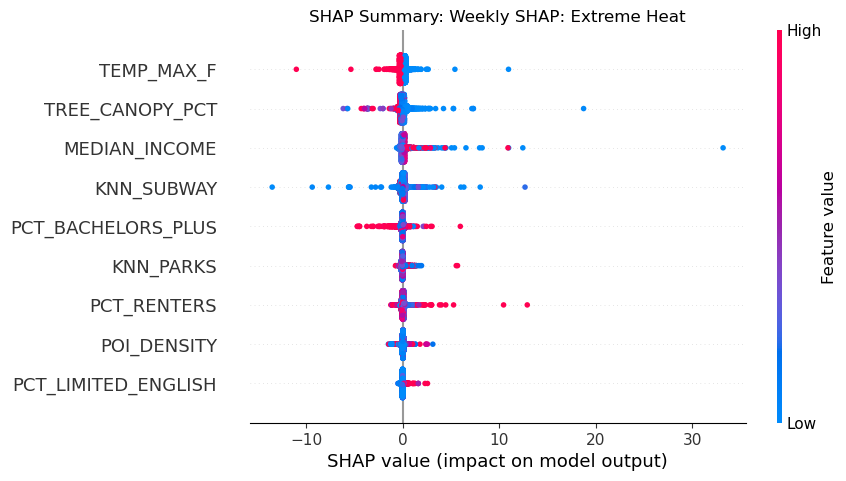

XGBoost R2 (Weekly SHAP: Normal Heat): 0.628


 99%|===================| 31044/31206 [02:43<00:00]        

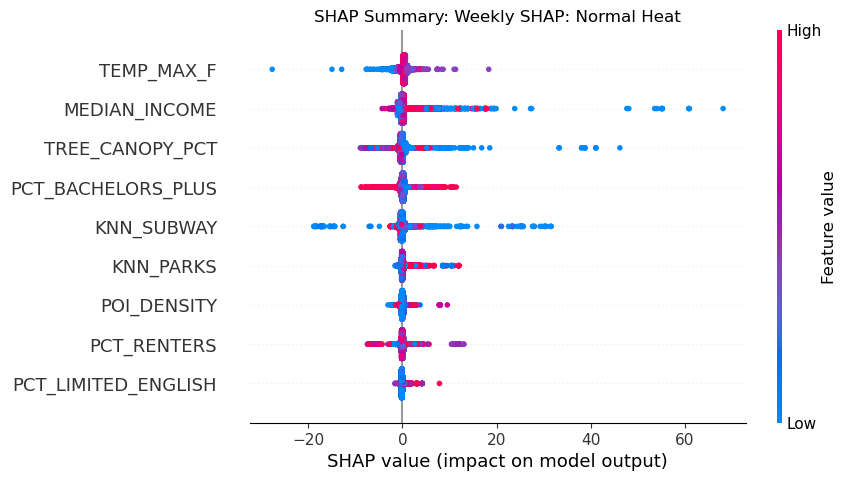

In [50]:
# Using weekly data for SHAP as it likely has better signal-to-noise ratio.
features = heat_variables + env_variables + acs_variables + urban_variables

def train_xgb_shap(df, label):
    X = df[features].copy()
    y = df["QOL_RATE_1K"].copy()

    # XGBoost Regressor.
    model = xgb.XGBRegressor(n_estimators = 300, max_depth = 4, learning_rate = 0.05)
    model.fit(X, y)
    
    print(f"XGBoost R2 ({label}): {model.score(X, y):.3f}")
    
    # SHAP.
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    
    # Plot.
    plt.figure()
    shap.plots.beeswarm(shap_values, max_display = 15, show = False)
    plt.title(f"SHAP Summary: {label}")
    plt.show()
    
    return shap_values

# Run SHAP on weekly data.
shap_high = train_xgb_shap(df_high_weekly, "Weekly SHAP: Extreme Heat")
shap_norm = train_xgb_shap(df_norm_weekly, "Weekly SHAP: Normal Heat")

XGBoost R2 (Daily SHAP: Extreme Heat): 0.471


 99%|===================| 11019/11145 [00:56<00:00]        

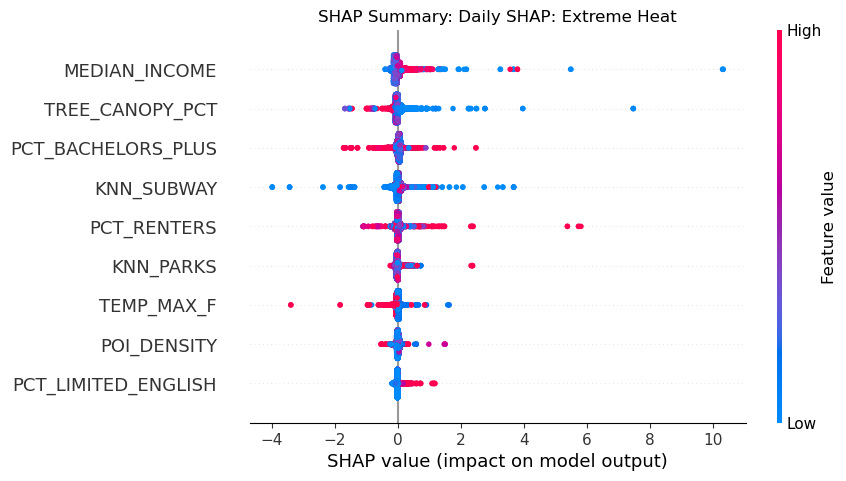

XGBoost R2 (Daily SHAP: Normal Heat): 0.302


100%|===================| 184913/185007 [16:42<00:00]        

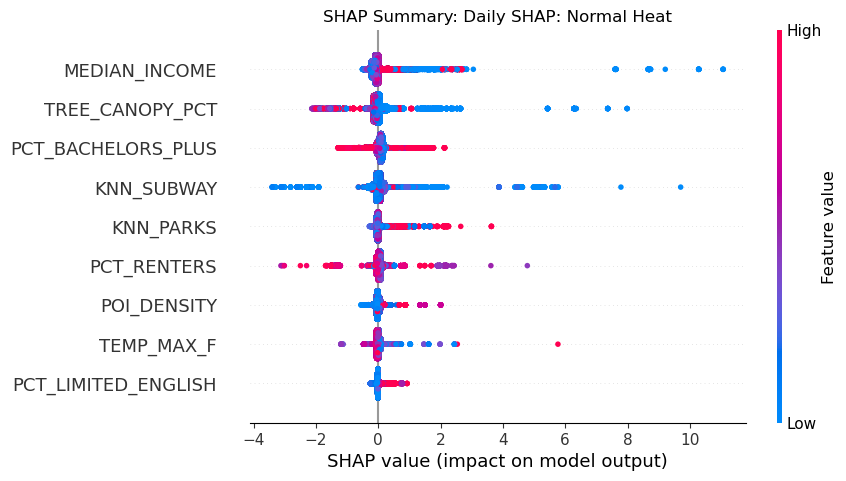

In [51]:
# Daily data for SHAP to compare. Takes MUCH longer.
shap_high = train_xgb_shap(df_high_daily, "Daily SHAP: Extreme Heat")
shap_norm = train_xgb_shap(df_norm_daily, "Daily SHAP: Normal Heat")